In [1]:
import time

from collections import OrderedDict
from pathlib import Path

import torch
from lib.structures.field_list import collect

from lib import utils, logger, config, modeling, solver, data

import os
import sys

%load_ext autoreload
%autoreload 2

In [2]:
# INPUT_IMG = 'data/front3d-sample/rgb_0007.png'
# OUTPUT_FOLDER = 'output/00/inference'
# CONFIG_FILE = 'configs/front3d_sample.yaml'
# MODEL = 'data/panoptic-front3d.pth'

In [3]:
config.merge_from_file('configs/front3d_train_3d_test.yaml')
model = modeling.PanopticReconstruction()
device = torch.device(config.MODEL.DEVICE)
model.to(device, non_blocking=True)
model.log_model_info()
model.fix_weights()

# Setup optimizer, scheduler, checkpointer
optimizer = torch.optim.Adam(model.parameters(), config.SOLVER.BASE_LR,
                                          betas=(config.SOLVER.BETA_1, config.SOLVER.BETA_2),
                                          weight_decay=config.SOLVER.WEIGHT_DECAY)
scheduler = solver.WarmupMultiStepLR(optimizer, config.SOLVER.STEPS, config.SOLVER.GAMMA,
                                                  warmup_factor=1,
                                                  warmup_iters=0,
                                                  warmup_method="linear")

-----------------------------------------
unet_output_channels 16
unet_fetures 16
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
#params discriminator 173808


In [4]:
# For Inference
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_64 = 1 # 10000
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_128 = 2 # 25000
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_256 = 3 #5000
config.MODEL.FRUSTUM3D.LEVEL_ITERATIONS_RGB = 4 #5000  #TO DO: Implement. Right now it is unused

In [5]:
model_dict = model.state_dict()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of Trainable Parameters: {}".format(pytorch_total_params))

output_path = Path('out')
checkpointer = utils.DetectronCheckpointer(model, optimizer, scheduler, output_path)

# Load the checkpoint
checkpoint_data = checkpointer.load()

checkpoint_arguments = {}
checkpoint_arguments["iteration"] = 0

if config.SOLVER.LOAD_SCHEDULER:
    checkpoint_arguments.update(checkpoint_data)

if config.MODEL.PRETRAIN2D:
    pretrain_2d = torch.load(config.MODEL.PRETRAIN2D)
    model.load_state_dict(pretrain_2d["model"])

# Dataloader
dataloader = data.setup_dataloader(config.DATASETS.TRAIN)

Number of Trainable Parameters: 10367125
Number of Trainable Parameters: 10367125


In [6]:
iteration = 0
iteration_end = time.time()
model.switch_training()

for idx, (image_ids, targets) in enumerate(dataloader):
    assert targets is not None, "error during data loading"
    data_time = time.time() - iteration_end
    # Get input images
    images = collect(targets, "color")

    # Pass through model
    # try:
    losses, results = model(images, targets)
    # except Exception as e:
    #     print(e, "skipping", image_ids[0])
    #     del targets, images
    #     continue

    # Accumulate total loss
    total_loss: torch.Tensor = 0.0
    log_meters = OrderedDict()
    rgb_loss = 0.0
    for loss_group in losses.values():
        for loss_name, loss in loss_group.items():
            if(loss_name == "rgb_total_loss"):
                # print("loss_name: {}, loss: {}".format(loss_name, loss))
                rgb_loss = loss
            if torch.is_tensor(loss) and not torch.isnan(loss) and not torch.isinf(loss):
                total_loss += loss
                log_meters[loss_name] = loss.item()

    # Loss backpropagation, optimizer & scheduler step
    optimizer.zero_grad()

    if torch.is_tensor(total_loss):
        # total_loss.backward()
        # optimizer.step()
        # scheduler.step()
        log_meters["total"] = total_loss.item()
    else:
        log_meters["total"] = total_loss

    # Minkowski Engine recommendation
    torch.cuda.empty_cache()

    # Save checkpoint
    # if iteration % config.SOLVER.CHECKPOINT_PERIOD == 0:
    #     checkpointer.save(f"model_{iteration:07d}", **checkpoint_arguments)

    last_training_stage = model.set_current_training_stage(iteration)

    # Save additional checkpoint after hierarchy level
    if last_training_stage is not None:
        # checkpointer.save(f"model_{last_training_stage}_{iteration:07d}", **checkpoint_arguments)
        logger.info(f"Finish {last_training_stage} hierarchy level")

    print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss), end="")
    if iteration%10 == 0:
        print("\riteration: {}, total_loss: {}, rgb_loss:{}".format(iteration, total_loss, rgb_loss))

    iteration += 1
    iteration_end = time.time()
    if iteration >= 7:
        break

/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/src/app/panoptic-reconstruction/lib/modeling/projection/sparse_projection.py:195: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  padding_offsets = difference // 2
/usr/local/lib/python3.8/dist-packages/MinkowskiEngine-0.5.1-py3.8-linux-x86_64.egg/MinkowskiEngine/MinkowskiSparseTensor.py:512: UserWarning: __floordiv__ is deprecated, and its behavior w

iteration: 0, total_loss: 0.03430289775133133, rgb_loss:0.0
iteration: 1, total_loss: 0.029597820714116096, rgb_loss:0.0

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:302: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:329: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 3, total_loss: 0.22769245505332947, rgb_loss:0.0

/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:412: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  predicted_coordinates[:, 1:] = predicted_coordinates[:, 1:] // prediction.tensor_stride[0]
/usr/src/app/panoptic-reconstruction/lib/modeling/frustum/frustum_completion.py:509: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_

iteration: 6, total_loss: 235.23870849609375, rgb_loss:62.83777999877933

## Sparse predictions

In [7]:
print(results.keys())
print(results['frustum'].keys())

geometry_sparse_prediction = results['frustum']['geometry']
rgb_sparse_prediction = results['frustum']['rgb']
semantic_sparse_prediction = results['frustum']['semantic3d']
print("geometry_sparse shape: ", geometry_sparse_prediction.shape)
print("rgb_sparse shape: ", rgb_sparse_prediction.shape)
print("semantic_sparse shape: ", semantic_sparse_prediction.shape)
aux_views = targets[0].get_field("aux_views").unsqueeze(0)
cam_poses = targets[0].get_field("cam_poses").unsqueeze(0)
# cam_poses[:,:,:,:3,-1] /= 0.0301
print("aux_views shape: ", aux_views.shape)
print("cam_poses shape: ", cam_poses.shape)

dict_keys(['depth', 'instance', 'projection', 'frustum'])
dict_keys(['occupancy_64', 'instance3d_64', 'semantic3d_64', 'occupancy_128', 'instance3d_128', 'semantic3d_128', 'occupancy_256', 'geometry', 'instance3d', 'instance3d_prediction', 'semantic3d', 'semantic3d_label', 'rgb'])
geometry_sparse shape:  torch.Size([101299, 1])
rgb_sparse shape:  torch.Size([101299, 3])
semantic_sparse shape:  torch.Size([101299, 13])
aux_views shape:  torch.Size([1, 3, 3, 240, 320])
cam_poses shape:  torch.Size([1, 3, 1, 4, 4])


In [8]:
target_sdf = collect(targets, "geometry")
print("target_sdf shape: ", target_sdf.shape)
print("target_sdf range: [{},{}]".format(target_sdf.min(), target_sdf.max()))

target_sdf shape:  torch.Size([1, 1, 256, 256, 256])
target_sdf range: [0.00016082213551271707,3.0]


=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
#params discriminator 173808


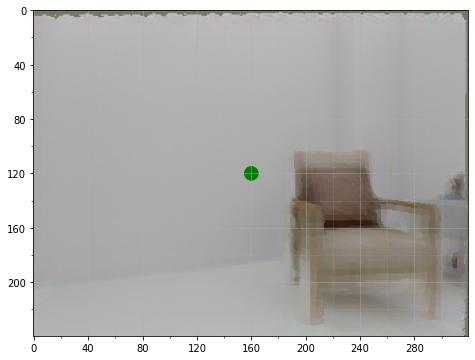

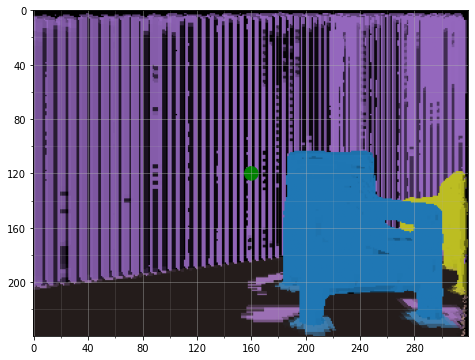

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


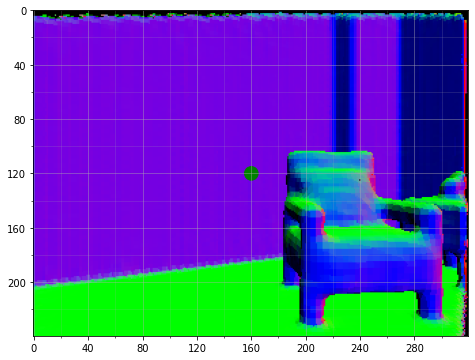

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


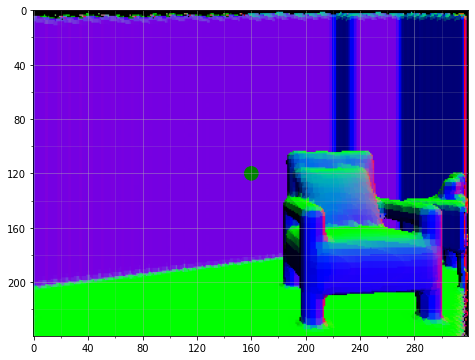

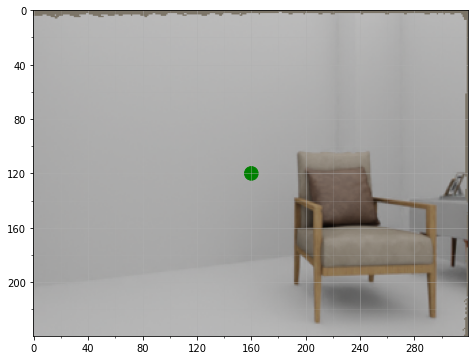

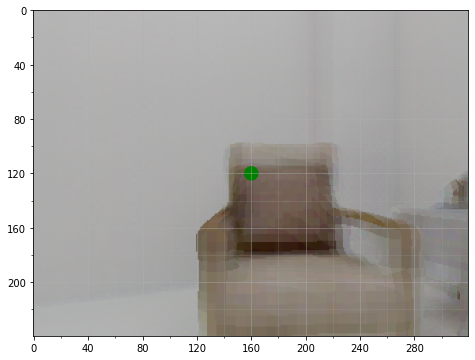

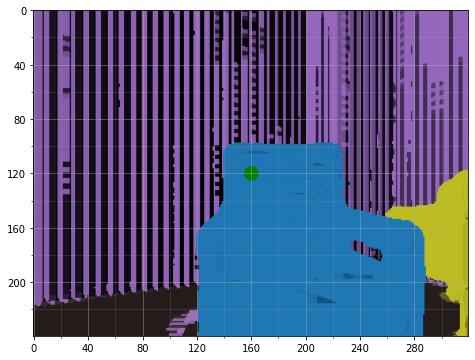

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


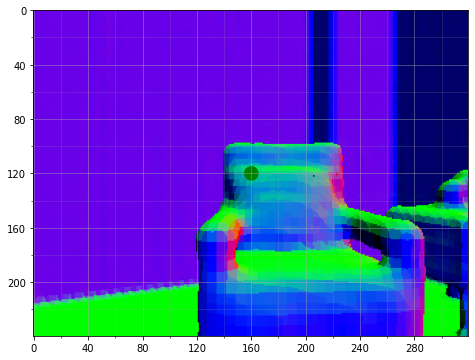

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


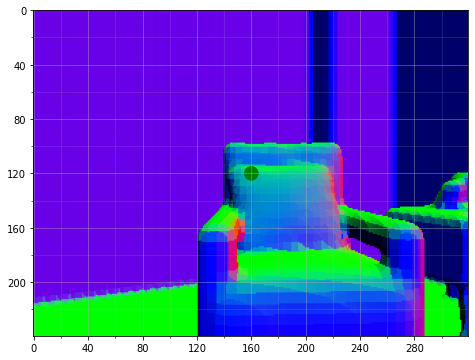

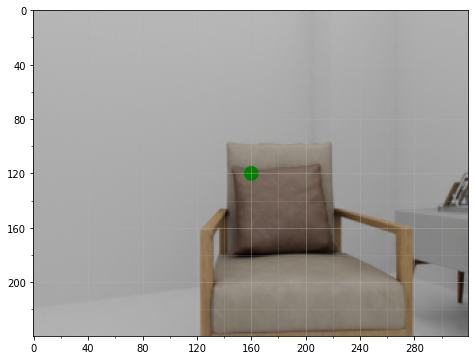

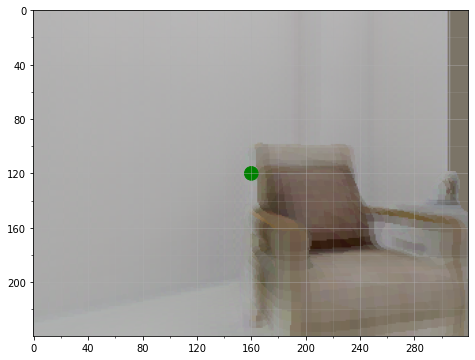

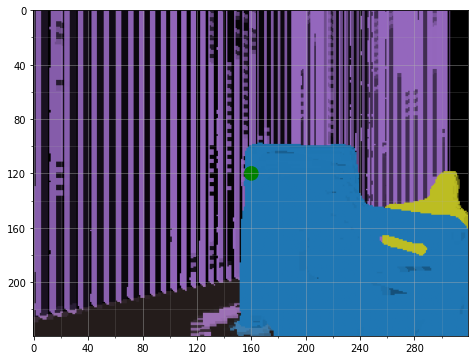

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


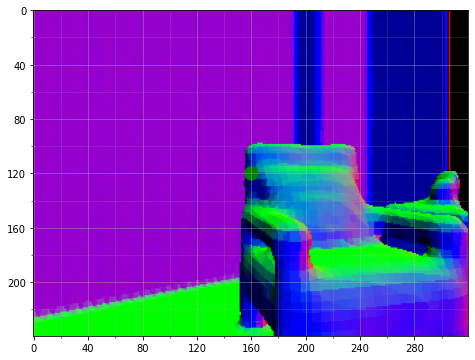

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


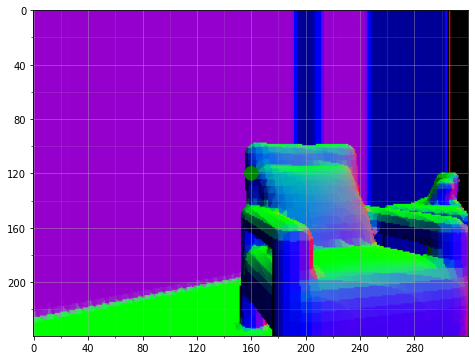

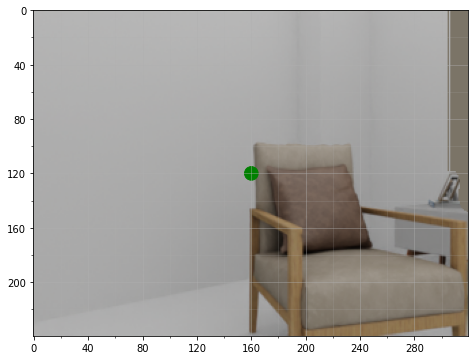

Total loss:  tensor(1.3084, device='cuda:0', grad_fn=<AddBackward0>)
L1 loss:  tensor(0.0682, device='cuda:0', grad_fn=<DivBackward0>)
style loss:  tensor(0.6762, device='cuda:0', grad_fn=<AddBackward0>)
loss_content:  tensor(165.3530, device='cuda:0', grad_fn=<AddBackward0>)
disc_loss:  tensor(1.3907, device='cuda:0', grad_fn=<AddBackward0>)
gen_loss:  tensor(0.6914, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [9]:
from lib.modeling.frustum.rgb_loss import RGBLoss
from plot_image_grid import plot_image

rgb_loss = RGBLoss()
loss = rgb_loss(geometry_sparse_prediction, rgb_sparse_prediction, semantic_sparse_prediction, aux_views, cam_poses.to(device), target_sdf, debug=True)

# Convert geometry ground truth from TDF to TSDF

In [9]:
# geometry = targets[0].get_field("geometry").squeeze()
# print("geometry shape: ", geometry.shape)
# print("geometry range: [{},{}]".format(geometry.min(),geometry.max()))

In [14]:
# Read geometry from file
import numpy as np
distance_field = np.load("data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/geometry_0001.npz")["data"]
print("geometry shape: ", distance_field.shape)
print("geometry range: [{},{}]".format(distance_field.min(),distance_field.max()))

geometry shape:  (256, 256, 256)
geometry range: [0.00016082213551271707,12.0]


## TDF to Mesh (non differentiable operation) using Marching Cubes

In [15]:
import lib.visualize as vis

if isinstance(geometry, torch.Tensor):
    distance_field = geometry.detach().cpu().numpy()

vertices, triangles = vis.get_mesh(distance_field, iso_value=1.0, truncation=12.0)
print("vertices shape: ", vertices.shape)
print("vertices range: [{},{}]".format(vertices.min(),vertices.max()))
print(triangles.shape)

vertices shape:  (42926, 3)
vertices range: [68.43592832405767,180.0131896696613]
(85868, 3)


## Mesh to TSDF

In [17]:
import trimesh
import mesh2sdf
import time

size = 256
level = 1 / size
mesh_scale = 1.0
### 
# bbmin = vertices.min(0)
# bbmax = vertices.max(0)
bbmin = np.array([0.0,0.0,0.0])
bbmax = np.array([255.0,255.0,255.0])
center = (bbmin + bbmax) * 0.5
scale = 2.0 * mesh_scale / (bbmax - bbmin).max()
vertices = (vertices-center) * scale
print("vertices range: [{},{}]".format(vertices.min(),vertices.max()))

###

t0 = time.time()
sdf_orig, mesh = mesh2sdf.compute(
    vertices, triangles, size, fix=True, level=level, return_mesh=True)
t1 = time.time()

# # # output
# mesh.vertices = mesh.vertices / scale + center

vertices range: [-0.463247620987783,0.41186815427185336]


In [18]:
print('It takes %.4f seconds to process' % (t1-t0))
print("sdf shape: ", sdf_orig.shape)
print("sdf range: [{},{}]".format(sdf_orig.min(),sdf_orig.max()))
print("mesh.vertices shape: ", mesh.vertices.shape)
print("mesh.vertices range: [{},{}]".format(mesh.vertices.min(),mesh.vertices.max()))
print(scale)

It takes 173.1550 seconds to process
sdf shape:  (256, 256, 256)
sdf range: [-0.019525444135069847,1.5412657260894775]
mesh.vertices shape:  (84533, 3)
mesh.vertices range: [-0.46536242961883545,0.4143359661102295]
0.00784313725490196


In [20]:
## Save
sdf_save = sdf_orig/scale

print("sdf_save shape: ", sdf_save.shape)
print("sdf_save range: [{},{}]".format(sdf_save.min(),sdf_save.max()))
sdf_save = np.clip(sdf_save, -12.0, 12.0)

np.savez("data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/geometry_sdf_0001.npz", sdf_save)
del sdf_save

sdf_save shape:  (256, 256, 256)
sdf_save range: [-2.4894940853118896,196.51136779785156]


In [188]:
# Get Dense Color Predictions
from lib.structures import DepthMap
import numpy as np
from typing import Tuple
from lib.structures.frustum import compute_camera2frustum_transform
_imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

color_image_size = (320, 240)

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION

# Get Dense Predictions
# geometry, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)
# semantics, _, _ = semantics_sparse.dense(dense_dimensions, min_coordinates)


rgb = rgb.squeeze()
print("rgb: {}".format(rgb.shape))
print("rgb values: [{},{}]".format(torch.max(rgb), torch.min(rgb)))


rgb: torch.Size([3, 256, 256, 256])
rgb values: [1.948082685470581,-2.1027653217315674]


In [189]:
# Render using spsg
truncation = 3.0
from torch.nn import functional as F

from pytorch3d.renderer import (
    look_at_view_transform,
)
from torch.nn import functional as F
def homogeneous_transform(R,t):
    last_row = torch.FloatTensor([[0,0,0,1]]).unsqueeze(0)
    T = torch.cat((R,t),dim=2)
    return torch.cat((T,last_row),dim=1)

sdf = torch.FloatTensor(sdf_orig/scale).to(device)
print("colors shape: ", rgb.shape)
print("sdf shape: ", sdf.shape)
print("sdf range: [{},{}]".format(sdf.min(),sdf.max()))

rgb = (F.interpolate(rgb.unsqueeze(0), size=(254,254,254), mode="trilinear", align_corners=True))[0]
sdf = (F.interpolate(sdf.unsqueeze(0).unsqueeze(0), size=(254,254,254), mode="trilinear", align_corners=True))[0,0]

sdf = sdf.unsqueeze(0).unsqueeze(0)
colors = rgb.permute(1,2,3,0).unsqueeze(0)
# Obtain sparse tensor of sdf, colors and semantic weights
locs = torch.nonzero(torch.abs(sdf[:,0]) < truncation)
locs = torch.cat([locs[:,1:], locs[:,:1]],1).contiguous()
vals = sdf[locs[:,-1],:,locs[:,0],locs[:,1],locs[:,2]].contiguous()
colors = colors[locs[:,-1],locs[:,0],locs[:,1],locs[:,2],:].float() #/255.0
print(locs.shape)
print("locs range: [{},{}]".format(locs.min(),locs.max()))

print(truncation)

colors shape:  torch.Size([3, 256, 256, 256])
sdf shape:  torch.Size([255, 255, 255])
sdf range: [-6.841657638549805,196.45570373535156]
torch.Size([154177, 4])
locs range: [0,189]
3.0


In [190]:
sys.path.append('/usr/src/app/spsg/torch')
from utils.raycast_rgbd.raycast_rgbd import RaycastRGBD
import loss as loss_util

truncation = 3.0
device = torch.device(config.MODEL.DEVICE)
input_dim = (254, 254, 254)
batch_size = 1
style_width = 320
style_height = 240
raycast_depth_max = 6.0
ray_increment = 0.003 * truncation
thresh_sample_dist = 100.5 * ray_increment
max_num_locs_per_sample = 640000
num_views = 3
voxelsize = 0.0301

=====================CREATING RAYCAST RGBD MODEL=====================
tensor([[[-4.3711e-08,  0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [-1.0000e+00,  0.0000e+00, -4.3711e-08]]])


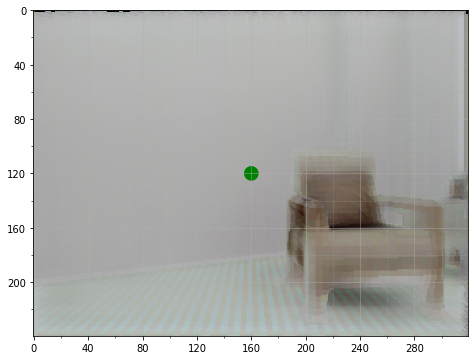

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


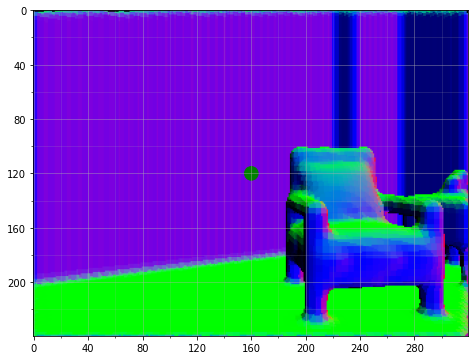

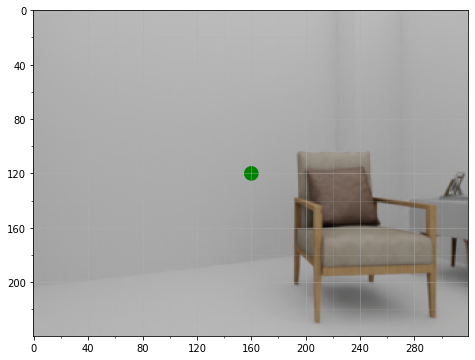

In [268]:
mult=1.0
# 311.76912635
intrinsics = torch.FloatTensor([[277.1281435*mult, 277.1281435*mult, 160.0, 120.0]]).to(device)
raycaster_rgbd = RaycastRGBD(batch_size, input_dim, style_width, style_height, depth_min=0.1/voxelsize, depth_max=raycast_depth_max/voxelsize, 
                                    thresh_sample_dist=thresh_sample_dist, ray_increment=ray_increment, max_num_locs_per_sample=max_num_locs_per_sample)

from plot_image_grid import plot_image
from PIL import Image
R0, t0 = look_at_view_transform(dist=-200, elev=0, azim=90)
t0 = torch.FloatTensor([[22.5,127.0,127.0]])
# R0, t0 = look_at_view_transform(eye= torch.FloatTensor([1.0,-1.0,-128.0]).unsqueeze(0), at=((-100, -200, 128), ), up=((0, 1, 0), ))
print(R0)
# Base Camera (original view) to Renderer World Transform
T_C1W = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0)).to(device)
view_matrix = T_C1W
_imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
raycast_color, _, raycast_normal = raycaster_rgbd(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
raycast_color = torch.fliplr(raycast_color[0])
raycast_normal = torch.fliplr(raycast_normal[0])

plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
plot_image(raycast_normal.detach().cpu().numpy())

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
plot_image(input_img)

## Render other views

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


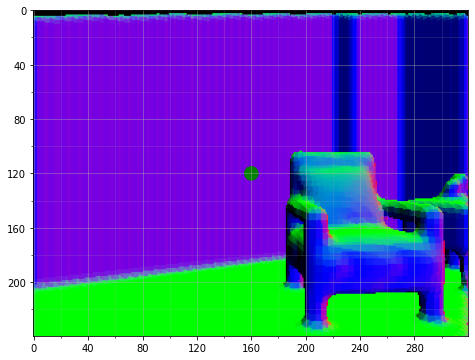

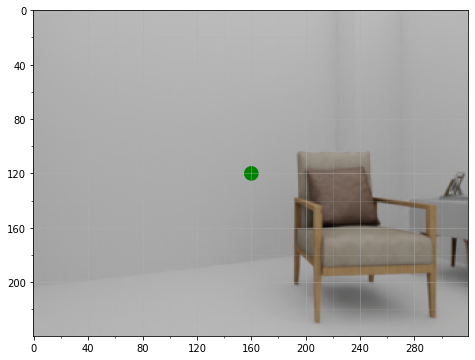

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


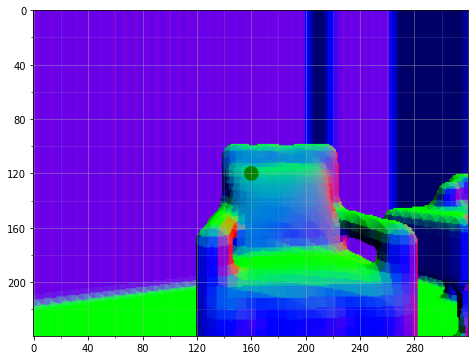

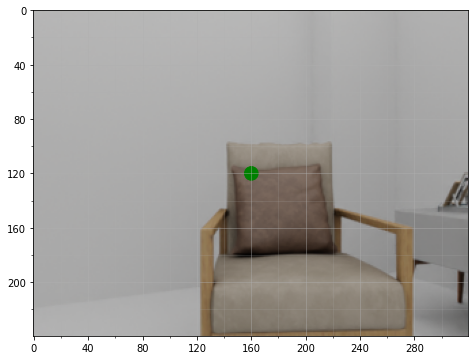

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


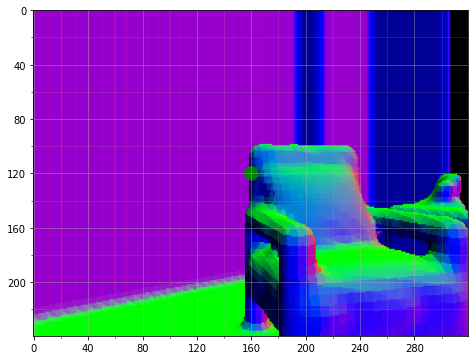

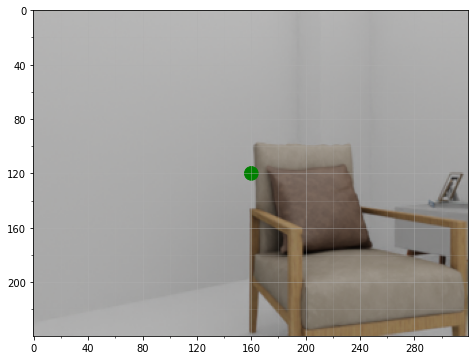

In [269]:
T_GC1 = cam_poses[0][0].to(device)
img_paths = ['data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png',
                'data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0005.png',
                'data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0018.png']
offsets = torch.FloatTensor([[0.0, -0.5, 0.0],[17.0,-0.5,21.5],[19.5,-0.5,11.7],]).to(device)*2.0 #[111.0,0.0,165.0]

for T_GC2, img_path, offset in zip(cam_poses[0], img_paths, offsets):
    T_GC2 = T_GC2.to(device)
    T_C2W = torch.matmul(torch.matmul(torch.inverse(T_GC2[0]), T_GC1[0]), T_C1W[0])
    T_C2W[:3,-1] += offset
    T_C2W = T_C2W.unsqueeze(0)
    view_matrix = T_C2W.clone()
    
    target_normals = loss_util.compute_normals_sparse(locs, vals, sdf.shape[2:], transform=torch.inverse(view_matrix))
    raycast_color, _, raycast_normal = raycaster_rgbd(locs.to(device), vals.to(device), colors.contiguous().to(device), target_normals.to(device), view_matrix.to(device), intrinsics.to(device))
    raycast_color = torch.fliplr(raycast_color[0])
    raycast_normal = torch.fliplr(raycast_normal[0])

    # plot_image(raycast_color.detach().cpu().numpy()*_imagenet_stats['std']+_imagenet_stats['mean'])
    plot_image(raycast_normal.detach().cpu().numpy())
    
    input_img = Image.open(img_path)
    plot_image(input_img)

# Pytorch3D volume rendering

In [202]:
# Get Dense Color Predictions
from lib.structures import DepthMap
import numpy as np
from typing import Tuple
from lib.structures.frustum import compute_camera2frustum_transform
_imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

color_image_size = (320, 240)

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION

# Get Dense Predictions
geometry, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)
# semantics, _, _ = semantics_sparse.dense(dense_dimensions, min_coordinates)


rgb = rgb.squeeze()
print("rgb: {}".format(rgb.shape))
print("rgb values: [{},{}]".format(torch.max(rgb), torch.min(rgb)))

print("geometry: {}".format(geometry.shape))
print("geometry values: [{},{}]".format(torch.max(geometry), torch.min(geometry)))

rgb: torch.Size([3, 256, 256, 256])
rgb values: [1.948082685470581,-2.1027653217315674]
geometry: torch.Size([1, 1, 256, 256, 256])
geometry values: [3.0,0.0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 256, 256, 256, 3])
x: [-3.8249998092651367.3.8249998092651367]
tensor([[256, 256, 256]], device='cuda:0')


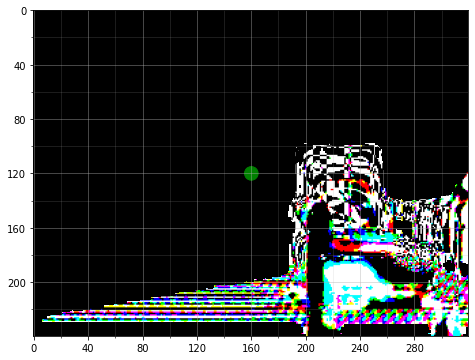

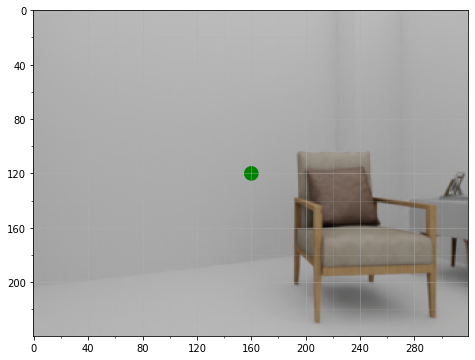

In [213]:
## Volume Rendering
from pytorch3d.structures import Volumes
from plot_image_grid import plot_image
from pytorch3d.structures import Volumes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PerspectiveCameras,
    OrthographicCameras,
    VolumeRenderer,
    NDCGridRaysampler,
    MonteCarloRaysampler,
    GridRaysampler,
    EmissionAbsorptionRaymarcher,
    AbsorptionOnlyRaymarcher,
    NDCMultinomialRaysampler,
    MultinomialRaysampler
)
color_image_size = (240, 320)
FOCAL_LENGTH1 = 277.1281435
FOCAL_LENGTH2 = 311.76912635
# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

volume_extent_world = 6.0
height, width = color_image_size
raysampler = NDCMultinomialRaysampler(
    image_width=width,
    image_height=height,
    n_pts_per_ray=150,
    # min_x = -3,
    # min_y = -3,
    # max_x = 3,
    # max_y = 3,
    min_depth = 0.1,
    max_depth = 6.0,
)
    

raymarcher = EmissionAbsorptionRaymarcher()

renderer = VolumeRenderer(
    raysampler=raysampler, raymarcher=raymarcher
)

image_size = torch.Tensor([height, width]).unsqueeze(0)


R, T = look_at_view_transform(eye= torch.FloatTensor([-3.0,0.0,0.0]).unsqueeze(0), at=((0, 0, 0), ), up=((0, -1, 0), ))


cameras = PerspectiveCameras(device=device, R=R, T=T, focal_length=((FOCAL_LENGTH1,FOCAL_LENGTH2),),
                             principal_point=(([160,120]),), image_size=((240, 320), ),in_ndc=False) #, K=front3d_intrinsic.unsqueeze(0))\

# cameras = PerspectiveCameras(device=device, R=R0, T=t0) #, K=front3d_intrinsic.unsqueeze(0))\

volume = Volumes(
    densities = geometry,
    features = rgb.unsqueeze(0),
    voxel_size = 0.03,
    volume_translation = torch.FloatTensor([0.0,0.0,0.0])
).to(device)

images = renderer(cameras=cameras, volumes=volume)

grid = volume.get_coord_grid()
print(grid.shape)
print("x: [{}.{}]".format(torch.min(grid), torch.max(grid)))
print(volume.get_grid_sizes())
image = images[0][0, ..., :3].cpu().detach().numpy()
plot_image(np.flip(image,axis=1))


from PIL import Image

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
plot_image(input_img)

=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
=====================CREATING RAYCAST RGBD MODEL=====================
#params discriminator 173040


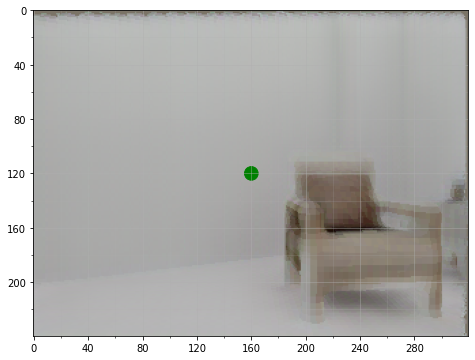

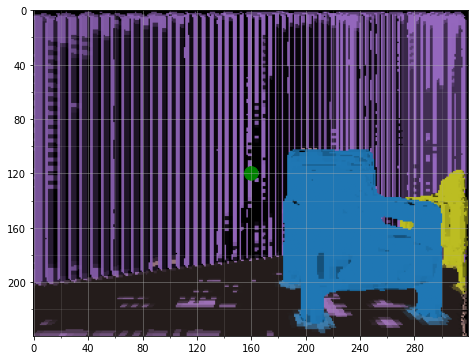

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


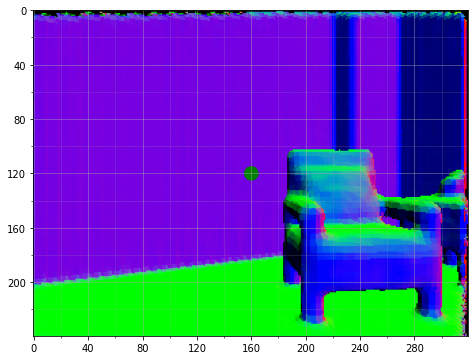

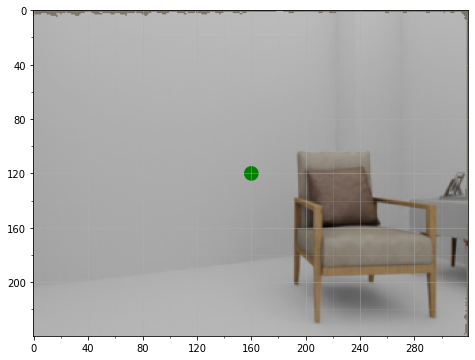

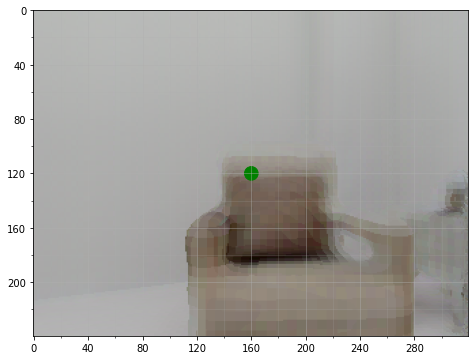

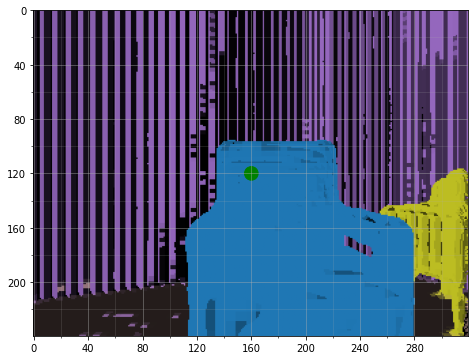

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


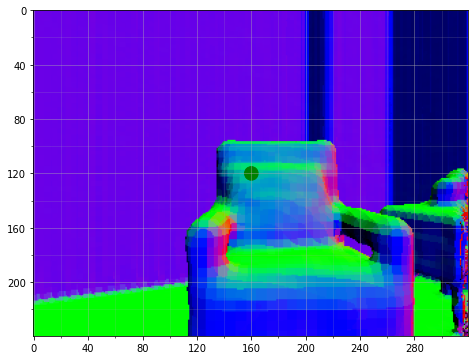

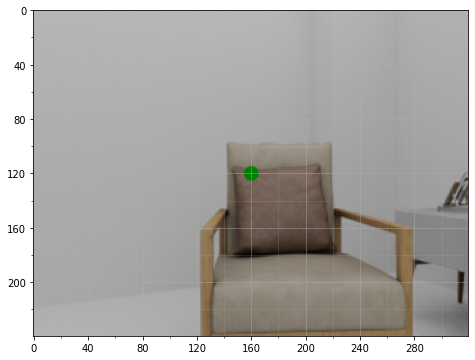

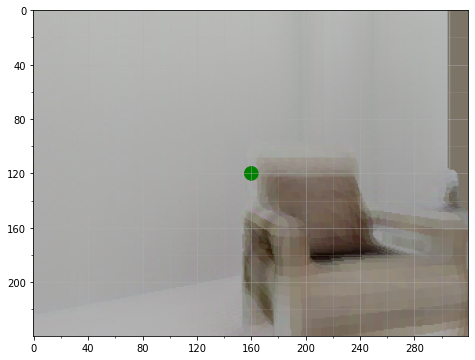

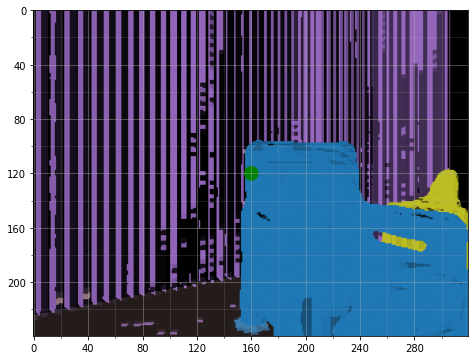

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


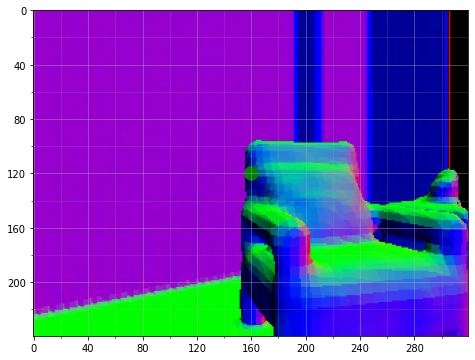

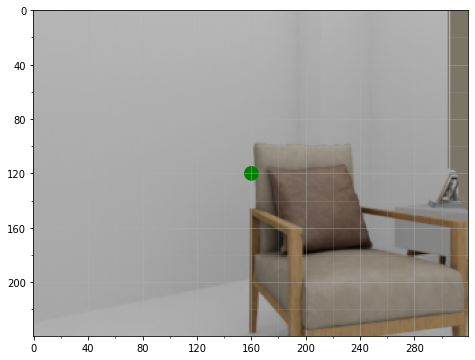

Total loss:  tensor(1.9579, device='cuda:0', grad_fn=<AddBackward0>)
L1 loss:  tensor(0.1010, device='cuda:0', grad_fn=<DivBackward0>)
style loss:  tensor(0.8251, device='cuda:0', grad_fn=<AddBackward0>)
loss_content:  tensor(217.9550, device='cuda:0', grad_fn=<AddBackward0>)
disc_loss:  tensor(1.3873, device='cuda:0', grad_fn=<AddBackward0>)
gen_loss:  tensor(0.7058, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [272]:
from lib.modeling.frustum.rgb_loss import RGBLoss
from plot_image_grid import plot_image
cam_poses2 = cam_poses.clone()
cam_poses2[:,:,:,:3,-1] *= 0.0301

rgb_loss = RGBLoss()
loss = rgb_loss(geometry_sparse_prediction, rgb_sparse_prediction, semantic_sparse_prediction, aux_views, cam_poses2.to(device), debug=True)